https://projects.volkamerlab.org/teachopencadd/talktorials/T007_compound_activity_machine_learning.html?highlight=morgan

In [ ]:
from pathlib import Path
from warnings import filterwarnings
import time

import pandas as pd
import numpy as np
from sklearn import svm, metrics, clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import auc, accuracy_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect

#from teachopencadd.utils import seed_everything

# Silence some expected warnings
#filterwarnings("ignore")
# Fix seed for reproducible results
#SEED = 22
#seed_everything(SEED)

In [ ]:
phenMD2 = pd.read_csv("C:\Users\Luke\Documents\University\Third Year\PCOL3888\Project New\molecule_Phenethylamines_valid.csv")
phenMD2

In [ ]:
phenMD2.set_index('Number')

,Name,SMILES,LogA
Number,,,
1,"1-(4-bromo-2,5dimethoxyphenyl)propan-2-amine",CC(Cc(c(OC)c1)cc(OC)c1Br)N,2.176
2,"2,5-dimethoxy-4-chloroamphetamine",CC(Cc(c(OC)c1)cc(OC)c1Cl)N,2.123
3,"2,5-dimethoxy-4-iodoamphetamine",CC(Cc(c(OC)c1)cc(OC)c1I)N,2.132
4,"2,5-dimethoxy-4-nitroamphetamine",CC(Cc(c(OC)c1)cc(OC)c1[N+]([O-])=O)N,1.903
5,"1-(4-ethyl-2,5-dimethoxyphenyl)propan-2-amine",CCc1cc(OC)c(CC(C)N)cc1OC,1.875
...,...,...,...
112,"2,5-dimethoxy-N-hydroxy-4-n-propylthio pheneth...",CCCSc(cc(c(CCNO)c1)OC)c1OC,1.176
113,"3,5-dimethoxy-4-methallyloxy phenethylamine",CC(COc(c(OC)cc(CCN)c1)c1OC)=C,1.040
114,"2-(benzo[d][1,3]dioxol-5-yl)-2-methoxyethanamine",COC(CN)c(cc1)cc2c1OCO2,0.477


In [ ]:
def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.

    """

    # convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        return np.array(GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits))
    if method == "morgan3":
        return np.array(GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

In [ ]:
compound_df = phenMD2.copy()

In [ ]:
# Add column for fingerprint
compound_df["fp"] = compound_df["SMILES"].apply(smiles_to_fp)
compound_df.head(3)
# NBVAL_CHECK_OUTPUT

,Number,Name,SMILES,LogA,fp
0,1,"1-(4-bromo-2,5dimethoxyphenyl)propan-2-amine",CC(Cc(c(OC)c1)cc(OC)c1Br)N,2.176,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,"2,5-dimethoxy-4-chloroamphetamine",CC(Cc(c(OC)c1)cc(OC)c1Cl)N,2.123,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,3,"2,5-dimethoxy-4-iodoamphetamine",CC(Cc(c(OC)c1)cc(OC)c1I)N,2.132,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
def smiles_to_fp(smiles, method="morgan2", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.

    """

    # convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        return np.array(GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits))
    if method == "morgan3":
        return np.array(GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

In [ ]:
# Add column for fingerprint
compound_df["fpm"] = compound_df["SMILES"].apply(smiles_to_fp)
compound_df.head(3)
# NBVAL_CHECK_OUTPUT

,Number,Name,SMILES,LogA,fp,fpm
0,1,"1-(4-bromo-2,5dimethoxyphenyl)propan-2-amine",CC(Cc(c(OC)c1)cc(OC)c1Br)N,2.176,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,"2,5-dimethoxy-4-chloroamphetamine",CC(Cc(c(OC)c1)cc(OC)c1Cl)N,2.123,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,3,"2,5-dimethoxy-4-iodoamphetamine",CC(Cc(c(OC)c1)cc(OC)c1I)N,2.132,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
def smiles_to_fp(smiles, method="morgan3", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.

    """

    # convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        return np.array(GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits))
    if method == "morgan3":
        return np.array(GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

In [ ]:
# Add column for fingerprint
compound_df["fpm3"] = compound_df["SMILES"].apply(smiles_to_fp)
compound_df.head(3)
# NBVAL_CHECK_OUTPUT

,Number,Name,SMILES,LogA,fp,fpm,fpm3
0,1,"1-(4-bromo-2,5dimethoxyphenyl)propan-2-amine",CC(Cc(c(OC)c1)cc(OC)c1Br)N,2.176,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,"2,5-dimethoxy-4-chloroamphetamine",CC(Cc(c(OC)c1)cc(OC)c1Cl)N,2.123,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,3,"2,5-dimethoxy-4-iodoamphetamine",CC(Cc(c(OC)c1)cc(OC)c1I)N,2.132,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
# Check that the new fp is different
print(compound_df['fpm'].equals(compound_df['fpm3']))

False


In [ ]:
# Keep only the columns we want
phen_maccs_df = compound_df[["Number", "SMILES", "LogA", "fp"]]
phen_maccs_df.head()
# NBVAL_CHECK_OUTPUT

,Number,SMILES,LogA,fp
0,1,CC(Cc(c(OC)c1)cc(OC)c1Br)N,2.176,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,CC(Cc(c(OC)c1)cc(OC)c1Cl)N,2.123,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,3,CC(Cc(c(OC)c1)cc(OC)c1I)N,2.132,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,4,CC(Cc(c(OC)c1)cc(OC)c1[N+]([O-])=O)N,1.903,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,5,CCc1cc(OC)c(CC(C)N)cc1OC,1.875,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
# Keep only the columns we want
phen_morg2_df = compound_df[["Number", "SMILES", "LogA", "fpm"]]
phen_morg2_df.head()
# NBVAL_CHECK_OUTPUT

,Number,SMILES,LogA,fpm
0,1,CC(Cc(c(OC)c1)cc(OC)c1Br)N,2.176,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,CC(Cc(c(OC)c1)cc(OC)c1Cl)N,2.123,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,3,CC(Cc(c(OC)c1)cc(OC)c1I)N,2.132,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,4,CC(Cc(c(OC)c1)cc(OC)c1[N+]([O-])=O)N,1.903,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,5,CCc1cc(OC)c(CC(C)N)cc1OC,1.875,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
# Keep only the columns we want
phen_morg3_df = compound_df[["Number", "SMILES", "LogA", "fpm3"]]
phen_morg3_df.head()
# NBVAL_CHECK_OUTPUT

,Number,SMILES,LogA,fpm3
0,1,CC(Cc(c(OC)c1)cc(OC)c1Br)N,2.176,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,CC(Cc(c(OC)c1)cc(OC)c1Cl)N,2.123,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,3,CC(Cc(c(OC)c1)cc(OC)c1I)N,2.132,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,4,CC(Cc(c(OC)c1)cc(OC)c1[N+]([O-])=O)N,1.903,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,5,CCc1cc(OC)c(CC(C)N)cc1OC,1.875,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
#Break out the fp into columns in a DF
phen_morg3_expanded = phen_morg3_df["fpm3"].apply(pd.Series)

In [ ]:
phen_morg3_expanded.insert(0, "Number", compound_df["Number"])

In [ ]:
phen_morg3_expanded.head(3)

,Number,0,1,2,3,4,5,6,7,8,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
phen_morg3_expanded.insert(2049, "LogA", compound_df["LogA"])
phen_morg3_expanded.head(3)

,Number,0,1,2,3,4,5,6,7,8,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,LogA
0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.176
1,2,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.123
2,3,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.132


In [ ]:
phen_morg3_expanded.to_csv('phenethylamine_M3_fp.csv',index=None)

In [ ]:
phen_maccs_df.head()

,Number,SMILES,LogA,fp
0,1,CC(Cc(c(OC)c1)cc(OC)c1Br)N,2.176,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,CC(Cc(c(OC)c1)cc(OC)c1Cl)N,2.123,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,3,CC(Cc(c(OC)c1)cc(OC)c1I)N,2.132,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,4,CC(Cc(c(OC)c1)cc(OC)c1[N+]([O-])=O)N,1.903,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,5,CCc1cc(OC)c(CC(C)N)cc1OC,1.875,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
phen_maccs_expanded = phen_maccs_df["fp"].apply(pd.Series)

In [ ]:
phen_maccs_expanded.head(2)

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
1,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0


In [ ]:
phen_maccs_expanded.head(2)

,Number,0,1,2,3,4,5,6,7,8,...,157,158,159,160,161,162,163,164,165,166
0,1,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
1,2,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0


In [ ]:
phen_maccs_expanded.insert(0, "Number", compound_df["Number"])

In [ ]:
phen_maccs_expanded.insert(168, "LogA", compound_df["LogA"])


In [ ]:
phen_maccs_expanded.head(3)

,Number,0,1,2,3,4,5,6,7,8,...,158,159,160,161,162,163,164,165,166,LogA
0,1,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,2.176
1,2,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,2.123
2,3,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,2.132


In [ ]:
phen_maccs_expanded.to_csv('phenethylamine_MACCS_fp.csv',index=None)

In [ ]:
phen_morg2_df.head()

,Number,SMILES,LogA,fpm
0,1,CC(Cc(c(OC)c1)cc(OC)c1Br)N,2.176,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,CC(Cc(c(OC)c1)cc(OC)c1Cl)N,2.123,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,3,CC(Cc(c(OC)c1)cc(OC)c1I)N,2.132,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,4,CC(Cc(c(OC)c1)cc(OC)c1[N+]([O-])=O)N,1.903,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,5,CCc1cc(OC)c(CC(C)N)cc1OC,1.875,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
phen_morg2_expanded = phen_morg2_df["fpm"].apply(pd.Series)

In [ ]:
phen_morg2_expanded.insert(0, "Number", compound_df["Number"])

In [ ]:
phen_morg2_expanded.shape

(114, 2049)

In [ ]:
phen_morg2_expanded.insert(2049, "LogA", compound_df["LogA"])

In [ ]:
phen_morg2_expanded.head()

,Number,0,1,2,3,4,5,6,7,8,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,LogA
0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.176
1,2,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.123
2,3,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.132
3,4,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.903
4,5,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.875


In [ ]:
phen_morg2_expanded.to_csv('phenethylamine_Morgan2_fp.csv',index=None)

In [ ]:
phen_maccs_expanded[phen_maccs_expanded.isna().any(axis=1)]

,Number,0,1,2,3,4,5,6,7,8,...,158,159,160,161,162,163,164,165,166,LogA


In [ ]:
X = phen_maccs_expanded.iloc[:,1:168]
y = phen_maccs_expanded['LogA'].values

In [ ]:
X.head(2)

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
1,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0


In [ ]:
y

array([2.176 , 2.123 , 2.132 , 1.903 , 1.875 , 1.9   , 1.698 , 1.602 ,
       1.505 , 1.    , 0.954 , 0.67  , 1.38  , 0.903 , 0.788 , 0.76  ,
       1.    , 0.788 , 1.255 , 1.079 , 0.602 , 1.176 , 0.477 , 0.845 ,
       0.3   , 1.633 , 1.    , 1.    , 1.176 , 0.301 , 0.301 , 0.477 ,
       0.398 , 0.698 , 0.602 , 0.477 , 0.602 , 0.903 , 1.568 , 1.27  ,
       1.176 , 1.146 , 1.342 , 1.23  , 1.041 , 1.462 , 0.954 , 1.204 ,
       1.322 , 0.845 , 0.602 , 0.602 , 1.342 , 0.477 , 0.114 , 0.    ,
       0.38  , 0.301 , 0.301 , 0.301 , 0.301 , 0.301 , 0.301 , 0.67  ,
       0.7788, 0.845 , 0.602 , 0.698 , 1.    , 1.079 , 0.602 , 0.58  ,
       0.602 , 0.301 , 0.301 , 0.602 , 0.602 , 0.602 , 0.301 , 0.602 ,
       1.    , 1.23  , 0.176 , 0.301 , 0.397 , 0.361 , 0.176 , 0.176 ,
       0.301 , 0.301 , 0.    , 1.698 , 1.68  , 0.788 , 0.301 , 1.255 ,
       0.    , 1.204 , 1.204 , 0.301 , 0.06  , 0.03  , 1.301 , 2.041 ,
       0.845 , 0.788 , 1.    , 0.602 , 1.176 , 1.176 , 1.04  , 0.477 ,
      

In [ ]:
X.shape  #- Before removal

(114, 167)

In [ ]:
from sklearn.feature_selection import VarianceThreshold

In [ ]:
sel = VarianceThreshold()
X=sel.fit_transform(X)
X.shape  #- After removal

(114, 93)

In [ ]:
x=X

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
from sklearn import set_config

R-squared: 0.8936395745008708
MSE:  0.4586547472744781
RMSE:  0.22932737363723904


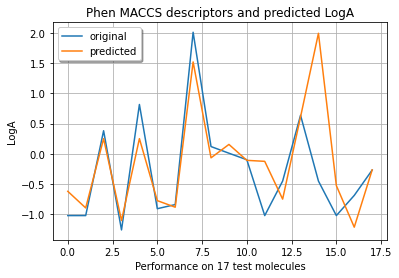

In [ ]:
#See: https://www.datatechnotes.com/2020/09/regression-example-with-randomforestregressor.html 
#RMSE jumps around a bit! The paper only looked at 23 hold out molecules but it depends on which ones are held out how well the performance will be.

x = scale(x)
y = scale(y)
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=.15)

rfr = RandomForestRegressor()
rfr.fit(xtrain, ytrain)

score = rfr.score(xtrain, ytrain)
print("R-squared:", score)

ypred = rfr.predict(xtest)

mse = mean_squared_error(ytest, ypred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0))

x_ax = range(len(ytest))
plt.plot(x_ax, ytest, label="original")
plt.plot(x_ax, ypred, label="predicted")
plt.title("Phen MACCS descriptors and predicted LogA")
plt.xlabel('Performance on 17 test molecules')
plt.ylabel('LogA')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

In [ ]:
0.15 * 114 

17.099999999999998